# Minimum Variance Portfolio Optimization with WRDS (CRSP Monthly Data)

This notebook demonstrates how to:
- Pull monthly stock return data from WRDS/CRSP
- Clean and validate coverage
- Estimate covariance matrices using **sample** and **Ledoit-Wolf shrinkage**
- Solve the **Global Minimum Variance (GMV)** portfolio with constraints
- Run a **rolling out-of-sample backtest**
- Compute metrics: annualized return, volatility, Sharpe ratio
- Analyze **turnover** and **weight stability**
- Export results and plots for reporting

In [27]:
# pip install cvxpy

In [28]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import wrds
from pandas.tseries.offsets import MonthEnd
from tqdm import tqdm


def data_acquisition():

    # Connect to WRDS database
    db = db_connect()

    # Get user inputs
    tickers = ticker_input()
    start_date_eval, look_back_period = date_input()
    max_missing = missing_months_input()
    all_data = pd.DataFrame()

    shrcd_list = [10, 11]  # Common shares

    # Get valid PERMNOs for the tickers
    permno_list, valid_tickers = get_active_permnos(
        db, tickers, start_date_eval, max_missing, shrcd_list
    )

    # Get returns data
    all_data = get_returns(db, permno_list, start_date_eval.strftime("%Y-%m-%d"))

    # Make the PERMNO columns into ticker columns and rename
    permno_to_ticker = dict(zip(permno_list, valid_tickers))
    all_data = all_data.rename(columns=permno_to_ticker)

    # Ask the user if we should set weight constraints
    max_weight, min_weight = weight_constraint_input()

    # Get the end date for the full data set
    end_date_eval = all_data.index.max()
    # Get the risk-free rate series based on the date range of the returns data
    risk_free_rate_series = get_risk_free_rate_series(
        db, start_date_eval, end_date_eval
    )

    df_full = get_crsp_monthly_panel(
        db, permno_list, start_date_eval.strftime("%Y-%m-%d")
    )

    # Close the WRDS connection
    db.close()

    return (
        all_data,
        valid_tickers,
        permno_list,
        start_date_eval,
        look_back_period,
        max_weight,
        min_weight,
        risk_free_rate_series,
        df_full,
    )


def db_connect():
    # Connect to WRDS database
    try:
        db = wrds.Connection()
        print("Connected to WRDS database.")
        return db
    except Exception as e:
        print("Failed to connect to WRDS database:", e)
        raise


def ticker_input():
    # Ask the user for a list of tickers (comma separated) with error handling
    while True:
        # Split by comma and strip whitespace and remove "
        tickers = input("Enter a list of stock tickers (comma separated): ").split(",")
        tickers = [ticker.strip().upper() for ticker in tickers]
        # Remove any surrounding quotes from each ticker
        tickers = [ticker.replace('"', "").replace("'", "") for ticker in tickers]
        # If the list is empty or contains only empty strings, ask again
        if not tickers or tickers == [""]:
            print("Invalid input. Please enter at least one ticker.")
        else:
            break
    print(f"Tickers: {tickers}")
    return tickers


def date_input():
    """
    Prompt for a start date (YYYY-MM-DD) and number of months (positive int),
    then return (start_date, number of months).
    """
    while True:
        try:
            # Get user input for start date and look back period
            start_str = input("Enter the start date (YYYY-MM-DD): ").strip()
            months_str = input(
                "Enter the number of months for the look back period: "
            ).strip()

            # Strict date parsing (won't accept "0")
            start_date = dt.strptime(start_str, "%Y-%m-%d")
            num_months = int(months_str)

            # If the number of months is not positive, ask again
            if num_months <= 0:
                print("Number of months must be a positive integer. Please try again.")
                continue

            # Compute and display the end date
            print(
                f"Date range: {pd.Timestamp(start_date).date()}, Number of months: {num_months}"
            )
            return pd.Timestamp(start_date), num_months

        except ValueError:
            print(
                "Invalid input. Use YYYY-MM-DD for the date and a positive integer for months."
            )


def missing_months_input():
    # Ask the user for the maximum number of allowed missing months with error handling
    while True:
        try:
            # Ask the user for the maximum number of allowed missing months with error handling
            max_missing = int(
                input("Enter the maximum number of allowed missing months: ")
            )
            # If the number is negative, ask again
            if max_missing < 0:
                print("Please enter a non-negative integer.")
            else:
                break
        # If the input is not an integer, ask again
        except ValueError:
            print("Invalid input. Please enter a non-negative integer.")
    print(f"Maximum allowed missing months: {max_missing}")
    return max_missing


def get_active_permnos(
    db, tickers: list, start_date: pd.Timestamp, max_missing: int, shrcd_list: list
):
    """
    Get active PERMNOs for the given tickers, max_missing, shrcd_list, and date range.
    """
    permno_list = []
    valid_tickers = []

    for ticker in tickers:
        # Get the active PERMNO for the ticker
        permno = pick_permno_for_ticker(db, ticker, start_date, max_missing, shrcd_list)
        # If there is no valid PERMNO found, ask the user for a replacement ticker
        while permno is None:
            print(f"No valid PERMNO found for ticker {ticker}.")
            ticker = input("Please enter a replacement ticker: ").strip().upper()
            permno = pick_permno_for_ticker(
                db, ticker, start_date, max_missing, shrcd_list
            )
        # If a valid PERMNO is found, add the PERMNO and ticker to the list
        permno_list.append(permno)
        valid_tickers.append(ticker)

    # Print the final list of valid tickers and PERMNOs
    print(f"Final tickers used: {valid_tickers}")
    print(f"Corresponding PERMNOs: {permno_list}")

    return permno_list, valid_tickers


def pick_permno_for_ticker(
    db, ticker: str, start_date: pd.Timestamp, max_missing: int, shrcd_list: list
) -> int | None:
    """
    Given a ticker and a date, pick the most appropriate PERMNO.

    Criteria (in order):
    1) Active on the start_date
    2) If multiple, pick the one with the namedt earliest

    Returns
    -------
    Selected PERMNO or None if no valid PERMNO found. Delisting dates.
    """
    q = f"""
    SELECT
        n.permno,
        n.namedt,
        n.nameendt,
        n.exchcd,
        n.shrcd
    FROM crsp.msenames AS n
    WHERE n.ticker = '{ticker}'
    ORDER BY n.namedt;
    """
    df = db.raw_sql(q)

    df["namedt"] = pd.to_datetime(df["namedt"])

    # IF there are no matches for the ticker, return None
    if df.empty:
        return None

    # Filter to only common shares in the allowed share codes
    df = df[df["shrcd"].isin(shrcd_list)]

    if df.empty:
        # Nothing in the allowed share codes
        print(
            f"Ticker {ticker} has no active PERMNOs in common share classes as of {start_date.date()}."
        )
        return None

    # Merge overlapping or touching name ranges per PERMNO
    df = collapse_name_ranges(df)

    # Filter to only PERMNOs active on the start_date
    active = df[df["namedt"] <= start_date]
    if active.empty:
        print(f"Ticker {ticker} has no active PERMNOs as of {start_date.date()}.")
        return None

    # Iterate over active PERMNOs and check for delisting and returns data
    for _, row in active.iterrows():
        permno = int(row["permno"])

        df1 = get_delistings(db, [permno], start_date.strftime("%Y-%m-%d"))
        df2 = get_returns(db, [permno], start_date.strftime("%Y-%m-%d"), max_missing)

        # If no delisting data and if the return data has < max_missing months, pick this PERMNO
        if df1.empty and isinstance(df2, pd.DataFrame) and not df2.empty:
            return permno
        elif not df1.empty:
            print("Delisting data found for PERMNO:", permno)
            print(df1)

    return None


def collapse_name_ranges(df: pd.DataFrame) -> pd.DataFrame:
    """
    Merge rows per permno when the next segment starts the day after (or earlier than)
    the previous segment ends (i.e., overlapping or touching intervals).

    Keeps only: permno, namedt, nameendt
    """
    # Create a copy of the input DataFrame to avoid modifying the original
    out = df.copy()

    # Ensure date columns are Timestamps and handle open-ended intervals
    out["namedt"] = pd.to_datetime(out["namedt"])
    out["nameendt"] = pd.to_datetime(out["nameendt"]).fillna(pd.Timestamp("9999-12-31"))

    # Sort within permno by start then end date
    out = out.sort_values(["permno", "namedt", "nameendt"])

    # Group by permno and shift to get previous end date
    prev_end = out.groupby("permno")["nameendt"].shift()

    # Start a new group when there is a gap (> 1 day).
    is_new_group = (prev_end.isna()) | (
        out["namedt"] > (prev_end + pd.Timedelta(days=1))
    )

    # Running group id per permno
    out["grp"] = is_new_group.groupby(out["permno"]).cumsum()

    # Aggregate each group to a single interval
    merged = (
        out.groupby(["permno", "grp"])
        .agg(namedt=("namedt", "min"), nameendt=("nameendt", "max"))
        .reset_index()
    )

    return merged[["permno", "namedt", "nameendt"]]


def get_returns(
    df_conn, permno_list: list, start: str, max_missing=None
) -> pd.DataFrame:
    """
    Wide monthly returns: index=date (Timestamp), columns=permno (int), values=ret (float).
    Missing/non-numeric RET are filled with 0.0 (policy choice).
    """
    # If the permno_list is empty, return an empty DataFrame
    if not permno_list:
        return pd.DataFrame()

    # Convert the values in the permno_list to integers
    permno_list = [int(p) for p in permno_list]

    q = f"""
        SELECT permno, date, ret
        FROM crsp.msf
        WHERE permno IN ({','.join(map(str, permno_list))})
          AND date >= '{start}'
        ORDER BY permno, date;
    """
    d = df_conn.raw_sql(q)

    # If the query returned no data, return an empty DataFrame
    if d.empty:
        return pd.DataFrame(index=pd.DatetimeIndex([], name="date"))

    # Ensure correct dtypes and alignment to month-end
    d["date"] = pd.to_datetime(d["date"]) + MonthEnd(0)  # ensure month-end
    d["ret"] = pd.to_numeric(d["ret"], errors="coerce")

    # Count missing per PERMNO before filling the output data
    if d["ret"].isna().any():
        miss_counts = d.loc[d["ret"].isna()].groupby("permno")["ret"].size()
    else:
        # If no missing, create a zero Series for all PERMNOs
        miss_counts = pd.Series(0, index=d["permno"].unique(), name="ret")

    # Enforce per-PERMNO missing threshold (if requested)
    if max_missing is not None:
        # Identify bad PERMNOs based on missing counts and max_missing
        bad_permnos = miss_counts[miss_counts > max_missing]
        # If any bad PERMNOs are found, print a warning and drop them
        if not bad_permnos.empty:
            print(
                f"Warning: dropping PERMNOs exceeding allowed missing months ({max_missing}): "
                f"{sorted(map(int, bad_permnos.index.tolist()))}"
            )
            d = d[~d["permno"].isin(bad_permnos.index)]

    # If everything was dropped, return an empty, well-formed frame
    if d.empty:
        return pd.DataFrame(index=pd.DatetimeIndex([], name="date"))

    # Fill remaining missing to 0.0
    n_missing_remaining = d["ret"].isna().sum()
    if n_missing_remaining:
        print(
            f"Info: {n_missing_remaining} missing returns (after filtering) "
            f"coerced to 0.0 across {d['permno'].nunique()} PERMNO(s)."
        )
        d["ret"] = d["ret"].fillna(0.0)

    # Pivot to wide format
    wide = (
        d.pivot(index="date", columns="permno", values="ret")
        .sort_index()
        .rename_axis(index="date", columns="permno")
        .astype(float)
    )
    return wide


def get_delistings(db, permno_list: list, start: str) -> pd.DataFrame:
    """
    Delisting returns aligned to month-end for merging with monthly CRSP returns.
    Returns long DataFrame with columns: permno (int), date (Timestamp month-end), dlret (float).
    """
    # If the permno_list is empty, return an empty DataFrame
    if not permno_list:
        return pd.DataFrame(columns=["permno", "date", "dlret"])

    # Convert the values in the permno_list to integers
    permno_list = [int(p) for p in permno_list]

    q = f"""
        SELECT permno, dlstdt, dlret
        FROM crsp.msedelist
        WHERE permno IN ({','.join(map(str, permno_list))})
          AND dlstdt >= '{start}'
          AND dlret IS NOT NULL
        ORDER BY permno, dlstdt;
    """
    df = db.raw_sql(q)

    # If the query returned no data, return an empty DataFrame
    if df.empty:
        return pd.DataFrame(columns=["permno", "date", "dlret"])

    # Ensure correct dtypes and alignment to month-end
    df["date"] = pd.to_datetime(df["dlstdt"]) + MonthEnd(0)  # align to month-end
    df["dlret"] = pd.to_numeric(df["dlret"], errors="coerce")
    df = df[["permno", "date", "dlret"]].dropna(subset=["dlret"])
    df["permno"] = df["permno"].astype(int)

    return df


def add_effective_returns(
    panel_wide: pd.DataFrame, delist_long: pd.DataFrame
) -> pd.DataFrame:
    """
    Merge delisting returns into a wide monthly returns panel and compute effective returns:
        ret_eff = (1 + ret) * (1 + dlret) - 1
    Returns a wide DataFrame with the same shape (date x permno), values=ret_eff.
    - If a month has both ret and dlret, they compound.
    - If only one is present, the other is treated as 0 (no effect).
    """
    if panel_wide.empty:
        return panel_wide
    if delist_long.empty:
        return panel_wide

    panel_wide = panel_wide.rename_axis(index="date", columns="permno")

    # Wide -> long for merge
    long = (
        panel_wide.stack()
        .rename("ret")
        .reset_index()
        # not needed if columns already named 'permno'
        .rename(columns={"level_1": "permno"})
    )
    # Ensure correct dtypes
    long["permno"] = long["permno"].astype(int)
    long["date"] = pd.to_datetime(long["date"])

    # Merge and compute effective returns
    merged = long.merge(delist_long, on=["permno", "date"], how="left")
    merged["ret"] = pd.to_numeric(merged["ret"], errors="coerce").fillna(0.0)
    merged["dlret"] = pd.to_numeric(merged["dlret"], errors="coerce").fillna(0.0)
    merged["ret_eff"] = (1.0 + merged["ret"]) * (1.0 + merged["dlret"]) - 1.0

    # Long -> wide
    out = (
        merged.pivot(index="date", columns="permno", values="ret_eff")
        .sort_index()
        .rename_axis(index="date", columns="permno")
        .astype(float)
    )

    # Preserve original index/columns union (optional)
    out = out.reindex(index=panel_wide.index.union(out.index)).reindex(
        columns=panel_wide.columns, fill_value=out.reindex(columns=panel_wide.columns)
    )
    # align to original dates/permnos
    out = out.reindex(index=panel_wide.index, columns=panel_wide.columns)
    return out


def weight_constraint_input():
    # Ask the user if they want to set max/min weight constraints
    def ask_yn(prompt: str) -> str:
        while True:
            # Ask the user for a 'y' or 'n' answer
            ans = input(prompt).strip().lower()
            if ans in {"y", "n"}:
                return ans
            print("Please answer 'y' or 'n'.")

    # ---- max (long) constraint ----
    set_max = ask_yn("Do you want to set maximum weight constraints? (y/n): ")
    max_weight = None
    # If yes, ask for the max weight value with error handling
    if set_max == "y":
        while True:
            try:
                # Ask the user for the maximum weight value with error handling
                max_weight = float(
                    input(
                        "Enter the maximum long position (e.g., 0.1 for 10%): "
                    ).strip()
                )
                # If the number is not positive, ask again
                if max_weight <= 0:
                    print("Please enter a positive number.")
                    continue
                break
            # If the input is not a number, ask again
            except ValueError:
                print("Invalid input. Please enter a positive number.")
        print(f"Maximum long position: {max_weight}")
    else:
        print("No maximum weight constraints set.")

    # ---- min (short) constraint ----
    set_min = ask_yn("Do you want to set maximum short position constraints? (y/n): ")
    min_weight = None
    # If yes, ask for the min weight value with error handling
    if set_min == "y":
        while True:
            try:
                min_weight = float(
                    input(
                        "Enter the maximum short position (e.g., -0.1 for -10%): "
                    ).strip()
                )
                if min_weight > 0:
                    print("Please enter a negative number (or zero for no shorting).")
                    continue
                break
            except ValueError:
                print("Invalid input. Please enter a negative number.")
        print(f"Maximum short position: {min_weight}")
    else:
        print("No minimum weight constraints set.")

    return max_weight, min_weight


def window_size_input():
    # Ask the user for the rolling window size (in months) with error handling
    while True:
        try:
            window_size = int(
                input(
                    "Enter the rolling window size (in months) for out-of-sample testing: "
                )
            )
            if window_size <= 0:
                print("Please enter a positive integer.")
            else:
                break
        except ValueError:
            print("Invalid input. Please enter a positive integer.")
    print(f"Rolling window size: {window_size} months")
    return window_size


def risk_free_rate_input():
    # Ask the user for the annual risk-free rate (as a decimal) with error handling
    while True:
        try:
            rf_rate = float(
                input(
                    "Enter the annual risk-free rate (as a decimal, e.g., 0.03 for 3%): "
                )
            )
            if rf_rate < 0:
                print("Please enter a non-negative number.")
            else:
                break
        except ValueError:
            print("Invalid input. Please enter a non-negative number.")
    print(f"Annual risk-free rate: {rf_rate}")
    return rf_rate


def get_risk_free_rate_series(db, start, end) -> pd.DataFrame:
    rf = db.get_table(library="ff", table="factors_monthly")[["date", "rf"]]
    rf["date"] = pd.to_datetime(rf["date"]) + MonthEnd(0)  # ensure month-end
    rf = rf.rename(columns={"rf": "risk_free_rate"})
    rf = rf[(rf["date"] >= start) & (rf["date"] <= end)]
    rf.set_index("date", inplace=True)
    return rf


def get_crsp_monthly_panel(db, permono_list: list, start_date: str) -> pd.DataFrame:
    """
    Pull the CRSP monthly panel *with* security descriptors via a time-bounded
    join to msenames (since shrcd/exchcd live in the name-history tables).

    Filters (can be edited):
      - U.S. common stocks: shrcd in (10, 11)
      - Major exchanges   : exchcd in (1, 2, 3)  # NYSE, AMEX, NASDAQ

    Returns
    -------
    DataFrame with date, permno, prc, shrout, ret, retx, shrcd, exchcd,
    and a computed market cap (mktcap).
    """
    # Convert start/end to Timestamps
    # start_dt = pd.to_datetime(start_date)

    q = f"""
    SELECT
        m.date,
        m.permno,
        m.permco,
        m.prc,
        m.shrout,
        m.ret,
        m.retx,
        n.shrcd,
        n.exchcd,
        n.ticker
    FROM crsp.msf AS m
    JOIN crsp.msenames AS n
        ON m.permno = n.permno
        AND m.date BETWEEN n.namedt AND COALESCE(n.nameendt, '9999-12-31') 
        -- A given stock (permno) can have multiple records in msenames over time: ticker changes, exchange moves, share code reclassifications, mergers.
    WHERE m.date >= '{start_date}'
        AND m.permno IN ({','.join(map(str, permono_list))})
        AND m.prc    IS NOT NULL
        AND m.shrout IS NOT NULL
    ORDER BY m.date, m.permno;
    """

    # Concatenate all yearly chunks
    df = db.raw_sql(q)

    # ---- Standardize dtypes and construct market cap ----
    if not df.empty:
        # Ensure correct dtypes
        df["date"] = pd.to_datetime(df["date"]) + MonthEnd(0)  # ensure month-end
        # CRSP price may be negative (indicating a bid/ask mid)
        df["prc"] = pd.to_numeric(df["prc"], errors="coerce").abs()
        # CRSP shares outstanding is in thousands
        df["shrout"] = (
            pd.to_numeric(df["shrout"], errors="coerce") * 1000.0
        )  # in thousands of shares
        df["ret"] = pd.to_numeric(df.get("ret", pd.Series()), errors="coerce")
        df["retx"] = pd.to_numeric(df.get("retx", pd.Series()), errors="coerce")
        # Calculate market cap based on price and shares outstanding
        df["mktcap"] = df["prc"] * df["shrout"]

    return df


In [29]:
import numpy as np
import pandas as pd
import cvxpy as cp
import os
import sys
import math
from copy import deepcopy
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
from IPython.display import display


def returns_to_excess(
    returns: pd.DataFrame, rf_df: pd.DataFrame | pd.Series
) -> pd.DataFrame:
    """
    Convert raw returns to excess returns by subtracting risk-free rate.
    returns : DataFrame of raw returns (assets in columns)
    """
    # Deep copy to avoid modifying input
    out = deepcopy(returns)
    # If rf_df is a 1-col DataFrame, squeeze to a Series
    rf = rf_df.squeeze() if isinstance(rf_df, pd.DataFrame) else rf_df
    # Align by index (in case one has extra/missing dates)
    rf = rf.reindex(out.index)
    # Vectorized row-wise subtraction across all columns
    out = out.sub(rf, axis=0)

    return out


def sample_covariance(ret_window):
    """
    Calculate sample covariance matrix from return window.
    """
    return ret_window.cov().values


def ledoit_wolf_covariance(ret_window):
    """
    Calculate Ledoit-Wolf shrinkage covariance matrix from return window.
    """
    lw = LedoitWolf().fit(ret_window.values)
    return lw.covariance_


def gmv_weights(cov_matrix, lower_bound=None, upper_bound=None):
    """
    Calculate Global Minimum Variance portfolio weights given a covariance matrix.
    lower_bound : minimum weight constraint (None for no constraint)
    upper_bound : maximum weight constraint (None for no constraint)
    """
    # Number of assets
    n = cov_matrix.shape[0]
    # Define optimization variable
    w = cp.Variable(n)

    # Define objective and constraints
    objective = cp.Minimize(cp.quad_form(w, cov_matrix))

    # Add sum-to-one constraint
    constraints = [cp.sum(w) == 1]
    # Add maximum weight constraints if specified
    if upper_bound is not None:
        constraints.append(w <= upper_bound)
    # Add minimum weight constraints if specified
    if lower_bound is not None:
        constraints.append(w >= lower_bound)

    # Solve the optimization problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP, verbose=False)

    # Return the optimized weights as a 1D numpy array
    return np.array(w.value).ravel()


def backtest_minvar(
    raw_returns_wide,
    excess_returns_wide,
    window_months=36,
    lower_bound=None,
    upper_bound=None,
):
    """
    Calculate rolling out-of-sample performance of GMV portfolios
    raw_returns_wide    : DataFrame of raw returns (assets in columns)
    excess_returns_wide : DataFrame of excess returns (assets in columns)
    window_months       : look-back window size in months
    lower_bound         : minimum weight constraint (None for no constraint)
    upper_bound         : maximum weight constraint (None for no constraint)

    Returns
    perf_df   : DataFrame with return and cumulative return columns
    weights_df: DataFrame with weight history in long format
    """
    # Get dates and tickers
    dates = excess_returns_wide.index
    tickers = list(excess_returns_wide.columns)
    # Initialize lists to store performance and weights
    perf_rows, weight_rows = [], []

    # Loop over each month in the backtest period
    for t in range(window_months, len(dates) - 1):
        # The estimation window is from t-window to t
        est_window = excess_returns_wide.iloc[t - window_months : t]

        # The next month's returns to evaluate performance
        next_raw_ret = raw_returns_wide.iloc[t + 1].values
        next_excess_ret = excess_returns_wide.iloc[t + 1].values

        # Calculate covariance matrices
        s_cov = sample_covariance(est_window)
        lw_cov = ledoit_wolf_covariance(est_window)

        # Calculate GMV weights
        w_sample = gmv_weights(s_cov, lower_bound, upper_bound)
        w_lw = gmv_weights(lw_cov, lower_bound, upper_bound)

        # Record performance
        perf_rows.append(
            {
                "date": dates[t + 1],
                "sample_return": np.dot(w_sample, next_raw_ret),
                "lw_return": np.dot(w_lw, next_raw_ret),
                "sample_excess_return": np.dot(w_sample, next_excess_ret),
                "lw_excess_return": np.dot(w_lw, next_excess_ret),
            }
        )

        # Record weights
        for i, tic in enumerate(tickers):
            weight_rows.append(
                {
                    "date": dates[t],
                    "method": "sample",
                    "ticker": tic,
                    "weight": w_sample[i],
                }
            )
            weight_rows.append(
                {
                    "date": dates[t],
                    "method": "ledoit_wolf",
                    "ticker": tic,
                    "weight": w_lw[i],
                }
            )

    # Convert lists to DataFrames
    perf_df = pd.DataFrame(perf_rows).sort_values("date").reset_index(drop=True)

    # Add cumulative return columns
    perf_df["sample_cum"] = (1 + perf_df["sample_return"]).cumprod()
    perf_df["lw_cum"] = (1 + perf_df["lw_return"]).cumprod()

    # Make weights_df a DataFrame
    weights_df = pd.DataFrame(weight_rows)

    return perf_df, weights_df


def summarize_performance(perf_df):
    """
    Summarize key performance metrics for each strategy.
    """
    summary = []

    # Loop over each strategy and compute metrics
    for label, col1, col2 in [
        ("sample", "sample_return", "sample_excess_return"),
        ("ledoit_wolf", "lw_return", "lw_excess_return"),
        ("equal_weighted", "ew_return", "ew_excess_return"),
        ("value_weighted", "vw_return", "vw_excess_return"),
        ("price_weighted", "pw_return", "pw_excess_return"),
    ]:
        # Compute annualized return, volatility, and Sharpe ratio
        ann_mean, ann_std = annualize_mean_std(perf_df[col1])
        sr = sharpe_ratio(perf_df[col2])

        # Append results to summary list
        summary.append(
            {
                "strategy": label,
                "annual_return": ann_mean,
                "annual_volatility": ann_std,
                "sharpe_ratio": sr,
            }
        )

    # Convert summary list to DataFrame
    summary_df = pd.DataFrame(summary)

    return summary_df


def annualize_mean_std(monthly_returns):
    """
    Annualize mean and standard deviation of monthly returns.
    """
    # Calculate mean and std of monthly returns
    mean_monthly = monthly_returns.mean()
    std_monthly = monthly_returns.std(ddof=1)

    # Annualize the monthly metrics
    ann_mean = (1 + mean_monthly) ** 12 - 1
    ann_std = std_monthly * math.sqrt(12)

    return ann_mean, ann_std


def sharpe_ratio(monthly_excess_returns):
    """
    Calculate annualized Sharpe ratio from monthly excess returns.
    Sharpe = sqrt(12) * (mean(excess) / std(excess))
    """
    sharpe = math.sqrt(12) * (
        (monthly_excess_returns.mean())
        / (
            monthly_excess_returns.std(ddof=1)
            # Handle case where std is zero
            if monthly_excess_returns.std(ddof=1) != 0
            else np.nan
        )
    )
    return sharpe


def turnover_series(weight_list: pd.DataFrame):
    """
    Compute monthly turnover series from weight history DataFrame.
    Turnover ≈ 0.5 * Σ_i |w_t,i − w_{t−1,i}|
    """
    if isinstance(weight_list, pd.DataFrame) and not weight_list.empty:
        W = weight_list.sort_index()
        # Compute absolute differences between consecutive rows
        dW = W.diff().abs()
        # Sum absolute differences across columns and scale by 0.5
        turnover = 0.5 * dW.sum(axis=1)
        turnover = turnover.iloc[1:]  # drop first (NaN) period
        turnover.name = "turnover"
    else:
        turnover = pd.Series(dtype=float, name="turnover")

    return turnover


def compute_turnover(weights_df):
    """
    Compute the monthly turnover for each method.
    Returns a DataFrame with columns: date, method, turnover
    """
    out = []
    # Loop over each method
    for method in weights_df["method"].unique():
        w = (
            weights_df[weights_df["method"] == method]
            .pivot(index="date", columns="ticker", values="weight")
            .sort_index()
        )
        for i in range(1, len(w)):
            prev, curr = w.iloc[i - 1].values, w.iloc[i].values
            out.append(
                {
                    "date": w.index[i],
                    "method": method,
                    "turnover": float(0.5 * np.sum(np.abs(curr - prev))),
                }
            )

    return pd.DataFrame(out)


def compute_weight_stability(weights_df: pd.DataFrame):
    """
    Compute the weight stability (dispersion) for each method.
    Calculated as the standard deviation of portfolio weights at each time point.
    """
    out = []
    for method in weights_df["method"].unique():
        w = (
            weights_df[weights_df["method"] == method]
            .pivot(index="date", columns="ticker", values="weight")
            .sort_index()
        )
        for i in range(len(w)):
            curr = w.iloc[i].values
            out.append(
                {
                    "date": w.index[i],
                    "method": method,
                    # Standard deviation of weights as a measure of dispersion
                    "weight_dispersion": float(np.std(curr)),
                }
            )

    return pd.DataFrame(out)


def drawdown_series(cum_series):
    """
    compute drawdown series and max drawdown
    cum_series : pd.Series of cumulative returns (growth of $1)
    returns    : (drawdown_series, max_drawdown_as_positive_float)
    """
    # Calculate drawdowns
    peak = cum_series.cummax()
    dd = (cum_series / peak) - 1.0
    # Max drawdown
    mdd = -dd.min()

    return dd, mdd


def rolling_sharpe_series(excess_monthly_returns, window=12):
    """
    rolling (annualized) sharpe using excess returns
    sharpe = sqrt(12) * (mean(excess) / std(excess))
    """
    rs = (
        np.sqrt(12)
        * excess_monthly_returns.rolling(window).mean()
        / excess_monthly_returns.rolling(window).std()
    )
    return rs


def sortino(excess):
    """
    Sortino ratio = sqrt(12) * (mean(excess) / downside deviation)
    """
    # Calculate downside deviation
    downside = excess[excess < 0]
    # Downside deviation is the standard deviation of negative returns
    dd = np.sqrt((downside**2).mean())

    return np.nan if dd == 0 else math.sqrt(12) * excess.mean() / dd


def drawdown_stats(cum):
    """
    compute max drawdown from cumulative returns series
    """
    # Calculate drawdowns
    peak = cum.cummax()
    # Drawdown is the current value divided by the peak value minus 1
    dd = cum / peak - 1

    return dd.min()


def turnover_avg(weights_df, method):
    """
    Compute average turnover for a given method.
    """
    w = (
        weights_df[weights_df["method"] == method]
        .pivot(index="date", columns="ticker", values="weight")
        .sort_index()
    )
    turns = []

    for i in range(1, len(w)):
        # Compute turnover as the sum of absolute weight changes
        prev, curr = w.iloc[i - 1].values, w.iloc[i].values
        turns.append(np.sum(np.abs(curr - prev)))

    return np.mean(turns) if turns else np.nan


def build_summary_plus(perf_df, weights_df):
    """
    Build an extended summary DataFrame with additional metrics.
    Returns a DataFrame with columns:
    strategy, ann_return, ann_vol, sharpe, sortino, max_dd, calmar,
    VaR95, CVaR95, hit_ratio, skew, kurtosis, avg_turnover, avg_weight_dispersion
    """

    rows = []
    for label, col1, col2 in [
        ("sample", "sample_return", "sample_excess_return"),
        ("ledoit_wolf", "lw_return", "lw_excess_return"),
        ("equal_weighted", "ew_return", "ew_excess_return"),
        ("value_weighted", "vw_return", "vw_excess_return"),
        ("price_weighted", "pw_return", "pw_excess_return"),
    ]:
        # Compute annualized return and volatility
        ann_r, ann_s = annualize_mean_std(perf_df[col1])
        # Compute Sharpe ratio
        sr = sharpe_ratio(perf_df[col2])
        # Compute Sortino ratio
        sor = sortino(perf_df[col2])
        # Compute the cumulative returns series
        cum = (1 + perf_df[col1]).cumprod()
        # Compute maximum drawdown
        mdd = drawdown_stats(cum)
        # Compute Calmar ratio
        calmar = ann_r / abs(mdd) if mdd < 0 else np.nan
        # Compute 5% VaR and CVaR
        var95 = perf_df[col1].quantile(0.05)
        cvar95 = perf_df[col1][perf_df[col1] <= var95].mean()
        # Compute hit ratio, skewness, and kurtosis
        hit = (perf_df[col1] > 0).mean()
        skew = perf_df[col1].skew()
        kurt = perf_df[col1].kurtosis()

        # Compute average turnover and weight dispersion for the method
        turn_df = compute_turnover(weights_df[weights_df["method"] == label])
        avg_turn_over = turn_df["turnover"].mean() if not turn_df.empty else np.nan

        stab_df = compute_weight_stability(weights_df[weights_df["method"] == label])
        avg_weight_dispersion = (
            stab_df["weight_dispersion"].mean() if not stab_df.empty else np.nan
        )

        # Append all metrics to the summary rows
        rows.append(
            {
                "strategy": label,
                "ann_return": ann_r,
                "ann_vol": ann_s,
                "sharpe": sr,
                "sortino": sor,
                "max_dd": mdd,
                "calmar": calmar,
                "VaR95": var95,
                "CVaR95": cvar95,
                "hit_ratio": hit,
                "skew": skew,
                "kurtosis": kurt,
                "avg_turnover": avg_turn_over,
                "avg_weight_dispersion": avg_weight_dispersion,
            }
        )

    return pd.DataFrame(rows)


def plot_cumulative(perf_df):
    """
    line chart: cumulative returns (growth of $1) for sample vs ledoit-wolf
    expects perf_df with columns: date, sample_cum, lw_cum
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(9, 5))
    plt.plot(perf_df["date"], perf_df["sample_cum"], label="gmv (sample)")
    plt.plot(perf_df["date"], perf_df["lw_cum"], label="gmv (ledoit-wolf)")
    plt.plot(perf_df["date"], perf_df["ew_cum"], label="equal weighted", linestyle="--")
    plt.plot(perf_df["date"], perf_df["vw_cum"], label="value weighted", linestyle="--")
    plt.plot(perf_df["date"], perf_df["pw_cum"], label="price weighted", linestyle="--")
    plt.title("cumulative return (growth of $1)")
    plt.xlabel("date")
    plt.ylabel("cumulative")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_drawdowns(perf_df):
    """
    line chart: drawdowns for sample vs ledoit-wolf
    expects perf_df with columns: date, sample_cum, lw_cum
    """
    import matplotlib.pyplot as plt

    dd_s, mdd_s = drawdown_series(perf_df["sample_cum"])
    dd_l, mdd_l = drawdown_series(perf_df["lw_cum"])
    dd_ew, mdd_ew = drawdown_series(perf_df["ew_cum"])
    dd_vw, mdd_vw = drawdown_series(perf_df["vw_cum"])
    dd_pw, mdd_pw = drawdown_series(perf_df["pw_cum"])

    plt.figure(figsize=(9, 4))
    plt.plot(perf_df["date"], dd_s, label=f"sample (mdd {mdd_s:.2%})")
    plt.plot(perf_df["date"], dd_l, label=f"ledoit-wolf (mdd {mdd_l:.2%})")
    plt.plot(
        perf_df["date"],
        dd_ew,
        label=f"equal weighted (mdd {mdd_ew:.2%})",
        linestyle="--",
    )
    plt.plot(
        perf_df["date"],
        dd_vw,
        label=f"value weighted (mdd {mdd_vw:.2%})",
        linestyle="--",
    )
    plt.plot(
        perf_df["date"],
        dd_pw,
        label=f"price weighted (mdd {mdd_pw:.2%})",
        linestyle="--",
    )
    plt.title("drawdown")
    plt.xlabel("date")
    plt.ylabel("drawdown")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_rolling_sharpe(perf_df, window=12):
    """
    line chart: rolling sharpe for sample vs ledoit-wolf
    expects perf_df with columns: date, sample_return, lw_return
    """
    import matplotlib.pyplot as plt

    rs_s = rolling_sharpe_series(perf_df["sample_excess_return"], window=window)
    rs_lw = rolling_sharpe_series(perf_df["lw_excess_return"], window=window)
    rs_ew = rolling_sharpe_series(perf_df["ew_excess_return"], window=window)
    rs_vw = rolling_sharpe_series(perf_df["vw_excess_return"], window=window)
    rs_pw = rolling_sharpe_series(perf_df["pw_excess_return"], window=window)

    plt.figure(figsize=(9, 4))
    plt.plot(perf_df["date"], rs_s, label="sample")
    plt.plot(perf_df["date"], rs_lw, label="ledoit-wolf")
    plt.plot(perf_df["date"], rs_ew, label="equal weighted")
    plt.plot(perf_df["date"], rs_vw, label="value weighted")
    plt.plot(perf_df["date"], rs_pw, label="price weighted")
    plt.title(f"rolling {window}-month sharpe")
    plt.xlabel("date")
    plt.ylabel("sharpe")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_turnover_timeseries(turnover_df):
    """
    line charts: turnover by method over time
    expects turnover_df with columns: date, method, turnover
    """
    import matplotlib.pyplot as plt

    # for method, grp in turnover_df.groupby("method"):
    #     plt.figure(figsize = (9, 3))
    #     plt.plot(grp["date"], grp["turnover"], label = method)
    #     plt.title(f"turnover — {method}")
    #     plt.xlabel("date")
    #     plt.ylabel("0.5 * sum |Δw|")
    #     plt.legend()
    #     plt.tight_layout()
    #     plt.show()
    df = turnover_df.sort_values("date").copy()

    fig, ax = plt.subplots(figsize=(10, 4))
    for method, grp in df.groupby("method"):
        ax.plot(grp["date"], grp["turnover"], label=method)

    ax.set_title("turnover by method over time")
    ax.set_xlabel("date")
    ax.set_ylabel("0.5 * sum |Δw|")
    ax.legend(title="method", ncol=2, loc="upper left")
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


def plot_weights_stability_timeseries(weights_stability_df):
    import matplotlib.pyplot as plt

    df = weights_stability_df.sort_values("date").copy()

    fig, ax = plt.subplots(figsize=(10, 4))
    for method, grp in df.groupby("method"):
        ax.plot(grp["date"], grp["weight_dispersion"], label=method)

    ax.set_title("weight dispersion by method over time")
    ax.set_xlabel("date")
    ax.set_ylabel("weight dispersion (std of portfolio weights)")
    ax.legend(title="method", ncol=2, loc="upper left")
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


def plot_turnover_distribution(turnover_df, bins=30):
    """
    histogram: turnover distribution by method
    expects turnover_df with columns: method, turnover
    """
    import matplotlib.pyplot as plt

    for method, grp in turnover_df.groupby("method"):
        plt.figure(figsize=(7, 4))
        plt.hist(grp["turnover"], bins=bins, alpha=0.85)
        plt.title(f"turnover distribution — {method}")
        plt.xlabel("0.5 * sum |Δw| per month")
        plt.ylabel("frequency")
        plt.tight_layout()
        plt.show()


def plot_corr_heatmap(returns_wide):
    """
    heatmap: asset correlation matrix for the universe used
    expects returns_wide wide DataFrame (assets in columns)
    """
    import matplotlib.pyplot as plt

    corr = returns_wide.corr()
    plt.figure(figsize=(7, 6))
    im = plt.imshow(corr.values, interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("asset correlation (in-sample universe)")
    plt.tight_layout()
    plt.show()


def show_summary_tables(summary_df, perf_df, turnover_df, tail_n=5):
    """
    display key tables inline for grading
    """
    from IPython.display import display

    display(summary_df)
    display(perf_df.tail(tail_n))
    display(turnover_df.tail(tail_n))


def save_csvs(perf_df, weights_df, turnover_df, stability_df, summary_df):
    """
    save results to csv for reporting (kept modular so you can call or skip)
    """
    perf_df.to_csv("oos_performance.csv", index=False)
    weights_df.to_csv("weights_history.csv", index=False)
    turnover_df.to_csv("turnover.csv", index=False)
    stability_df.to_csv("stability.csv", index=False)
    summary_df.to_csv("summary_metrics.csv", index=False)


def make_all_charts(perf_df, turnover_df, weights_stability_df, returns_wide=None):
    """
    one-click plot routine that produces all required visuals
    """
    plot_cumulative(perf_df)
    plot_drawdowns(perf_df)
    plot_rolling_sharpe(perf_df, window=12)
    plot_turnover_timeseries(turnover_df)
    plot_turnover_distribution(turnover_df)
    plot_weights_stability_timeseries(weights_stability_df)
    if returns_wide is not None:
        plot_corr_heatmap(returns_wide)


def build_topn_indexes(panel: pd.DataFrame, look_back_period: int) -> pd.DataFrame:
    """
    Construct Equal-, Value-, and Price-Weighted index levels.

    Methodology:
    - At month t, use constituents & weights formed from month t-1 information.
    - Grow the index from t-1 to t using 'ret' (should include delistings if available).

    Returns
    -------
    (weights_df, returns_df)
      weights_df: columns ['EW Weights','VW Weights','PW Weights'], indexed by month t (from the 2nd month on);
                  each cell is a pd.Series of permno->weight for that month.
      returns_df: columns ['EW Returns','VW Returns','PW Returns'], indexed by month t (from the 2nd month on).
    """

    import pandas as pd
    from tqdm import tqdm

    # Sort & prep
    panel = panel.sort_values(["date", "permno"])
    # Unique months (respect lookback but keep at least 2 months for t-1/t pairing)
    months_all = pd.Index(panel["date"].drop_duplicates().sort_values())
    months = months_all[look_back_period:]
    if len(months) < 2:
        raise ValueError("Not enough months after look_back_period to compute indices.")

    # Fast month lookup
    by_month = {d: g for d, g in panel.groupby("date")}

    # Levels start at 1.0 at the first available month in our slice
    ew_level = [1.0]
    vw_level = [1.0]
    pw_level = [1.0]

    # Per-month weights and returns (start at t = months[1], since we need t-1)
    ew_w_list, vw_w_list, pw_w_list = [], [], []
    ew_ret_list, vw_ret_list, pw_ret_list = [], [], []

    # Loop over t (needs t-1)
    for i in tqdm(range(1, len(months)), desc="Index Calculation Progress"):
        t_1, t = months[i - 1], months[i]
        g_t1 = by_month.get(t_1, pd.DataFrame()).dropna(
            subset=["mktcap", "prc"], how="any"
        )
        g_t = by_month.get(t, pd.DataFrame())

        if g_t1.empty or g_t.empty:
            # carry forward last level; returns = 0; weights empty
            ew_level.append(ew_level[-1])
            vw_level.append(vw_level[-1])
            pw_level.append(pw_level[-1])

            ew_w_list.append(pd.Series(dtype=float))
            vw_w_list.append(pd.Series(dtype=float))
            pw_w_list.append(pd.Series(dtype=float))

            ew_ret_list.append(0.0)
            vw_ret_list.append(0.0)
            pw_ret_list.append(0.0)
            continue

        # Choose universe by mktcap at t-1 (Top-N if you want: .head(N))
        chosen = g_t1.sort_values("mktcap", ascending=False).set_index("permno")

        # Effective returns at t for chosen names (ensure alignment & numeric dtype)
        g_t = g_t.set_index("permno")
        common = chosen.index.intersection(g_t.index)
        if len(common) == 0:
            ew_level.append(ew_level[-1])
            vw_level.append(vw_level[-1])
            pw_level.append(pw_level[-1])

            ew_w_list.append(pd.Series(dtype=float))
            vw_w_list.append(pd.Series(dtype=float))
            pw_w_list.append(pd.Series(dtype=float))

            ew_ret_list.append(0.0)
            vw_ret_list.append(0.0)
            pw_ret_list.append(0.0)
            continue

        r_t = pd.to_numeric(g_t.loc[common, "ret"], errors="coerce")

        # ----- Equal-Weighted -----
        r_ew = r_t.dropna()
        if r_ew.empty:
            ew_gross = 1.0
            ew_weights = pd.Series(dtype=float)
        else:
            ew_weights = pd.Series(1.0 / len(r_ew), index=r_ew.index)
            ew_gross = (1.0 + r_ew).mean()

        # ----- Value-Weighted (mktcap at t-1) -----
        w_vw_raw = pd.to_numeric(chosen.loc[common, "mktcap"], errors="coerce")
        mask_vw = r_t.notna() & w_vw_raw.notna() & (w_vw_raw > 0)
        r_vw = r_t.loc[mask_vw]
        if r_vw.empty:
            vw_gross = 1.0
            vw_weights = pd.Series(dtype=float)
        else:
            w_vw = w_vw_raw.loc[mask_vw]
            w_vw = w_vw / w_vw.sum()
            vw_weights = w_vw.copy()
            vw_gross = ((1.0 + r_vw) * w_vw).sum()

        # ----- Price-Weighted (price at t-1) -----
        w_pw_raw = pd.to_numeric(chosen.loc[common, "prc"], errors="coerce").abs()
        mask_pw = r_t.notna() & w_pw_raw.notna() & (w_pw_raw > 0)
        r_pw = r_t.loc[mask_pw]
        if r_pw.empty:
            pw_gross = 1.0
            pw_weights = pd.Series(dtype=float)
        else:
            w_pw = w_pw_raw.loc[mask_pw]
            w_pw = w_pw / w_pw.sum()
            pw_weights = w_pw.copy()
            pw_gross = ((1.0 + r_pw) * w_pw).sum()

        # Update levels
        ew_level.append(ew_level[-1] * float(ew_gross))
        vw_level.append(vw_level[-1] * float(vw_gross))
        pw_level.append(pw_level[-1] * float(pw_gross))

        # Store weights (at month t) and returns (gross-1)
        ew_w_list.append(ew_weights)
        vw_w_list.append(vw_weights)
        pw_w_list.append(pw_weights)

        ew_ret_list.append(float(ew_gross - 1.0))
        vw_ret_list.append(float(vw_gross - 1.0))
        pw_ret_list.append(float(pw_gross - 1.0))

    # -------- Assemble outputs --------
    idx_months = pd.to_datetime(months[:-1])  # all months incl. the first (level=1.0)
    idx_rt = pd.to_datetime(months[1:])  # returns/weights start at second month

    # Weights: store the per-month Series in an object-dtype Series
    ew_weights_s = pd.Series(ew_w_list, index=idx_months, name="EW Weights")
    vw_weights_s = pd.Series(vw_w_list, index=idx_months, name="VW Weights")
    pw_weights_s = pd.Series(pw_w_list, index=idx_months, name="PW Weights")
    weights_df = pd.concat([ew_weights_s, vw_weights_s, pw_weights_s], axis=1)

    # Returns
    ew_returns_s = pd.Series(ew_ret_list, index=idx_rt, name="ew_return")
    vw_returns_s = pd.Series(vw_ret_list, index=idx_rt, name="vw_return")
    pw_returns_s = pd.Series(pw_ret_list, index=idx_rt, name="pw_return")
    returns_df = pd.concat([ew_returns_s, vw_returns_s, pw_returns_s], axis=1)

    weights_df = weights_to_long(weights_df, panel, map_from_t_minus_1=True)
    # # (Optional) Levels, if you want them:
    levels_df = pd.DataFrame(
        {
            "ew_cum": ew_level[1:],
            "vw_cum": vw_level[1:],
            "pw_cum": pw_level[1:],
        },
        index=idx_rt,
    )

    # print(levels_df.tail())

    return weights_df, returns_df, levels_df  # or (levels_df, weights_df, returns_df)


def weights_to_long(
    weights_df: pd.DataFrame, panel: pd.DataFrame, map_from_t_minus_1: bool = True
) -> pd.DataFrame:
    """
    Convert the 'weights_df' returned by build_topn_indexes into long/tidy format:

        date       method   ticker   weight

    Assumptions
    -----------
    - weights_df index = month-end Timestamp for t (starts at months[1:])
    - Each cell in weights_df is a pd.Series indexed by PERMNO with weight values
    - 'panel' has at least ['date','permno','ticker'] (one row per stock per month)
    - If tickers change over time, mapping can be taken from t-1 (default) or t
    """
    import pandas as pd
    from pandas.tseries.offsets import MonthEnd

    # Keep only what's needed and make a month→(permno→ticker) map
    if not {"date", "permno", "ticker"}.issubset(panel.columns):
        raise ValueError("`panel` must contain columns: 'date', 'permno', 'ticker'.")

    p = panel[["date", "permno", "ticker"]].drop_duplicates()
    month_map = {d: g.set_index("permno")["ticker"] for d, g in p.groupby("date")}

    rows = []
    for dt, row in weights_df.iterrows():
        # Choose which month to use for the permno→ticker mapping
        key = (dt - MonthEnd(1)) if map_from_t_minus_1 else dt
        tickmap = month_map.get(key, month_map.get(dt, pd.Series(dtype=object)))

        for method_name, s in row.items():
            if s is None or len(s) == 0:
                continue
            # Ensure it's a Series with permno index
            s = pd.Series(s, copy=False)
            df = s.rename("weight").reset_index().rename(columns={"index": "permno"})
            # Map ticker; if missing, fall back to permno as string
            df["ticker"] = df["permno"].map(tickmap).fillna(df["permno"].astype(str))
            df["date"] = pd.to_datetime(dt)
            # Clean method label (e.g., "EW Weights" -> "ew")
            df["method"] = (
                str(method_name)
                .replace(" Weights", "")
                .replace("_weights", "")
                .strip()
                .lower()
            )
            rows.append(df[["date", "method", "ticker", "weight"]])

    out = (
        pd.concat(rows, ignore_index=True)
        .sort_values(["date", "method", "ticker"])
        .reset_index(drop=True)
    )

    # rename columns from ev to equal_weighted, etc
    method_map = {
        "ew": "equal_weighted",
        "vw": "value_weighted",
        "pw": "price_weighted",
    }
    out["method"] = out["method"].replace(method_map)

    return out


In [30]:
# default ticker universe
default_tickers = ["NVDA", "MSFT", "AAPL", "AMZN", "GOOGL", "TSLA", 
                   "GOOG", "JPM", "V", "LLY", "NFLX", "XOM", "MA", "ORCL", "WMT", 
                   "JNJ", "COST", "HD", "ABBV", "PG", "BAC", "UNH", "GE", 
                   "CVX", "WFC", "CSCO", "AMD", "IBM", "KO", "PM", "GS", "CRM", 
                   "ABT", "CAT", "MCD", "DIS", "T", "MRK", 
                   "NOW", "MS", "INTU", "PEP", "C", "AXP", "MU", "VZ", "QCOM", 
                   "TMO", "BLK", "TXN", "LRCX", "SCHW", "AMAT", "BA", 
                   "TJX", "ISRG", "NEE", "ADBE", "INTC", "ANET", 
                   "APH", "AMGN", "BSX", "PGR", "COF", "ETN", "LOW", "KLAC", "UNP", 
                   "GILD", "PANW", "PFE", "HON", "SYK", "ADI", "MDT", 
                   "COP", "DHR", "ADP", "DE", "CMCSA", "TMUS", "MO"]

# backtest parameters
start_date = "2015-01-01"
end_date   = "2025-06-30"
look_back_period = 36 # int: months
lower_bound = -0.10
upper_bound =  0.20
max_missing = 10

shrcd_list = [10, 11]  # U.S. common stocks

In [31]:
start_date = pd.to_datetime(start_date)
start_date.strftime('%Y-%m-%d')

'2015-01-01'

### Get Monthly Returns from WRDS/CRSP

We query **CRSP monthly stock file (crsp.msf)** joined with `msenames` for tickers.
The query returns monthly simple returns for each ticker.


### Data Coverage Validation

We require each ticker to have sufficient non-missing history:
- Within each rolling window, allow at most `max_missing` gaps.
- Drop tickers that fail this test.
- Then drop any remaining rows with NaNs.


In [32]:
# Connect to WRDS and fetch data
db = wrds.Connection()

# Get active permnos for the default tickers, filtering by shrcd and max missing
permno_list, valid_tickers = get_active_permnos(db, default_tickers, start_date, max_missing, shrcd_list)

# Fetch returns and risk-free rate series
raw_returns_wide = get_returns(db, permno_list, start_date)
end_date = raw_returns_wide.index.max()
risk_free_rate_series = get_risk_free_rate_series(db, start_date, end_date)

# Get full CRSP monthly panel to creating equal, value-, and price-weighted indexes
df_full = get_crsp_monthly_panel(db, permno_list, start_date)

# Close the WRDS connection
db.close()

WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
Final tickers used: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'GOOGL', 'TSLA', 'GOOG', 'JPM', 'V', 'LLY', 'NFLX', 'XOM', 'MA', 'ORCL', 'WMT', 'JNJ', 'COST', 'HD', 'ABBV', 'PG', 'BAC', 'UNH', 'GE', 'CVX', 'WFC', 'CSCO', 'AMD', 'IBM', 'KO', 'PM', 'GS', 'CRM', 'ABT', 'CAT', 'MCD', 'DIS', 'T', 'MRK', 'NOW', 'MS', 'INTU', 'PEP', 'C', 'AXP', 'MU', 'VZ', 'QCOM', 'TMO', 'BLK', 'TXN', 'LRCX', 'SCHW', 'AMAT', 'BA', 'TJX', 'ISRG', 'NEE', 'ADBE', 'INTC', 'ANET', 'APH', 'AMGN', 'BSX', 'PGR', 'COF', 'ETN', 'LOW', 'KLAC', 'UNP', 'GILD', 'PANW', 'PFE', 'HON', 'SYK', 'ADI', 'MDT', 'COP', 'DHR', 'ADP', 'DE', 'CMCSA', 'TMUS', 'MO']
Corresponding PERMNOs: [86580, 10107, 14593, 84788, 90319, 93436, 14542, 47896, 92611, 50876, 89393, 11850, 91233, 10104, 55976, 22111, 87055, 66181, 13721, 18163, 59408, 92655, 12060, 14541, 38703, 76076, 61241, 12490, 11308, 926

### Covariance Estimators

- **Sample covariance**: standard historical estimate
- **Ledoit–Wolf shrinkage**: more stable estimator (reduces noise)


### Global Minimum Variance Portfolio

We solve:

$$
\min_{w} \; w^T \Sigma w
$$

subject to:

$$\sum_i w_i = 1$$  
$$l \leq w_i \leq u \;\;\; \forall i$$  
**130/30 gross exposure constraints**:  
  $$\sum_i w_i^+ \leq 1.30, \quad \sum_i w_i^- \leq 0.30$$  

Where:
- **w** : vector of portfolio weights  
- **Σ** : covariance matrix of asset returns  
- **wᵢ** : weight of asset *i*  
- **l, u** : lower and upper bounds on each asset’s weight  
- **wᵢ⁺** : positive part of wᵢ (long exposure)  
- **wᵢ⁻** : negative part of wᵢ (short exposure)  


In [33]:
# Build top-N indexes for the equal-, value-, and price-weighted strategies
topn_weights_df, topn_raw_returns_df, topn_levels_df = build_topn_indexes(df_full, look_back_period)

# Compute excess returns for the top-N strategies
topn_excess_returns_df = returns_to_excess(topn_raw_returns_df, risk_free_rate_series)
for col in topn_excess_returns_df.columns:
    topn_excess_returns_df = topn_excess_returns_df.rename(columns={col: col.split('_')[0] + '_excess_return'})

# Sort the columns alphabetically for easier comparison
raw_returns_wide = raw_returns_wide.reindex(sorted(raw_returns_wide.columns), axis=1)

# Compute excess returns for the GMV strategies
excess_returns_wide = returns_to_excess(raw_returns_wide, risk_free_rate_series)

# Backtest the minimum variance portfolios
perf_df, weights_df = backtest_minvar(raw_returns_wide, excess_returns_wide, \
                                        look_back_period, lower_bound, upper_bound)
perf_df = perf_df.set_index('date')

# Combine performance DataFrames
perf_df = pd.concat([perf_df, topn_raw_returns_df, topn_excess_returns_df, topn_levels_df], axis=1)
perf_df = perf_df.reset_index()

# Combine weights history
weights_df = pd.concat([weights_df, topn_weights_df], axis=0)

# Compute average risk-free rate over the period for annualization
monthly_rf = risk_free_rate_series.mean()

Index Calculation Progress: 100%|██████████| 83/83 [00:00<00:00, 301.06it/s]


In [34]:
# Export perf_df and weights_df to CSV for reporting
perf_df.to_csv("mvo_performance.csv", index=False)
weights_df.to_csv("mvo_weights.csv", index=False)

### Performance Metrics

We compute:
- Annualized return
- Annualized volatility (std dev)
- Sharpe ratio (using annual risk-free rate)
- Portfolio turnover and weight stability


In [23]:
summary_df = summarize_performance(perf_df)
print("\nSummary statistics for Minimum Variance Portfolio:")
display(summary_df)


Summary statistics for Minimum Variance Portfolio:


,strategy,annual_return,annual_volatility,sharpe_ratio
0,sample,0.080811,0.156220,0.355279
1,ledoit_wolf,0.098703,0.144138,0.500022
2,equal_weighted,0.195213,0.175829,0.893097
3,value_weighted,0.190079,0.176239,0.866973
4,price_weighted,0.209763,0.193597,0.874524


In [24]:
summary_plus_df = build_summary_plus(perf_df, weights_df)
print("\nExtended Portflio Summary Statistics")
display(summary_plus_df)


Extended Portflio Summary Statistics


,strategy,ann_return,ann_vol,sharpe,sortino,max_dd,calmar,VaR95,CVaR95,hit_ratio,skew,kurtosis,avg_turnover,avg_weight_dispersion
0,sample,0.080811,0.156220,0.355279,0.405399,-0.126005,0.641328,-0.061157,-0.070989,0.518072,0.344629,0.215090,0.615186,0.063732
1,ledoit_wolf,0.098703,0.144138,0.500022,0.514897,-0.150483,0.655905,-0.063175,-0.071634,0.590361,-0.040067,0.097781,0.260495,0.036901
2,equal_weighted,0.195213,0.175829,0.893097,0.838223,-0.211515,0.922927,-0.081878,-0.091731,0.674699,-0.228826,0.277841,0.000000,0.000000
3,value_weighted,0.190079,0.176239,0.866973,0.826577,-0.242093,0.785150,-0.078255,-0.091065,0.650602,-0.340805,-0.138307,0.024280,0.016020
4,price_weighted,0.209763,0.193597,0.874524,0.862408,-0.282586,0.742296,-0.081045,-0.099347,0.662651,-0.261332,0.131047,0.029533,0.015449


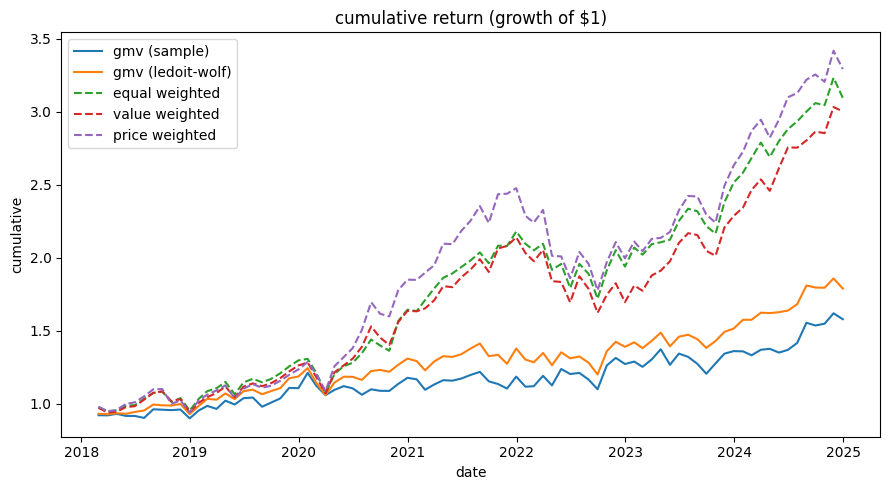

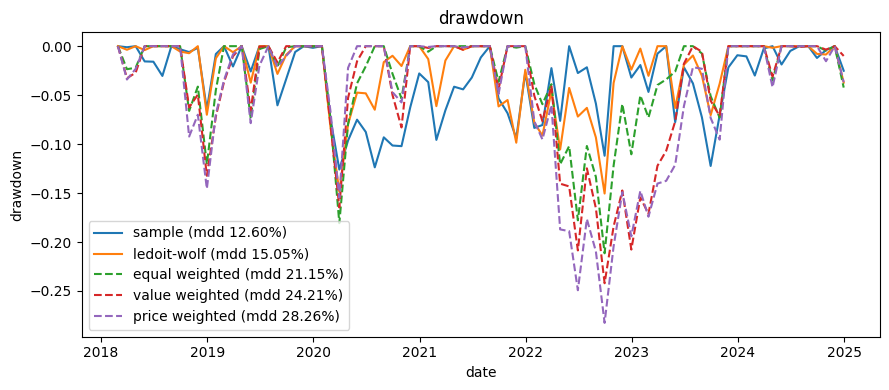

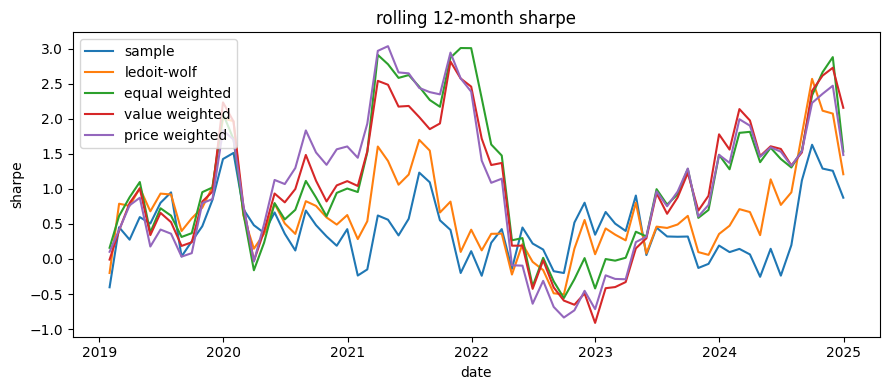

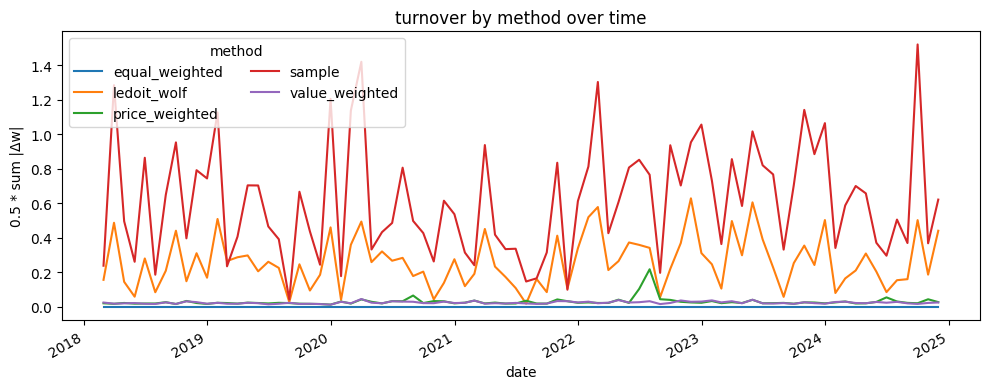

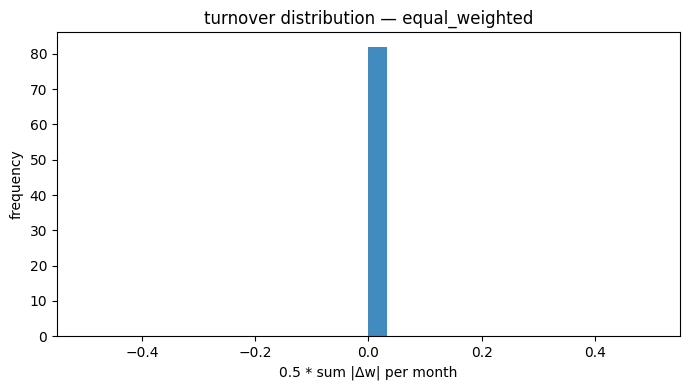

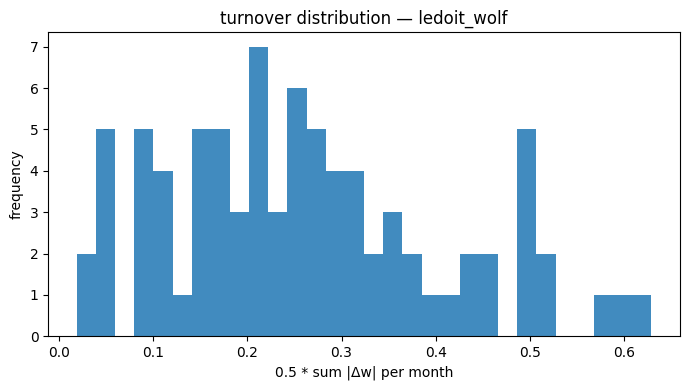

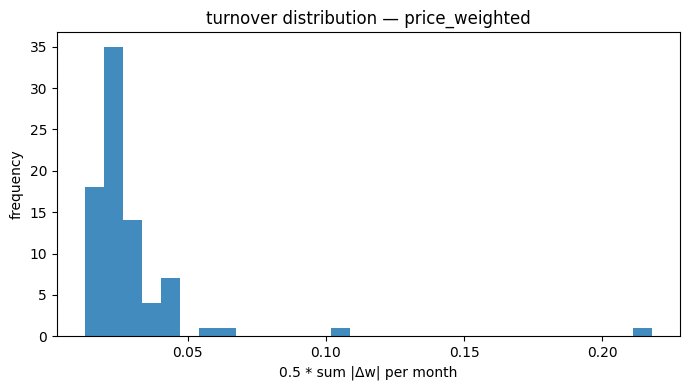

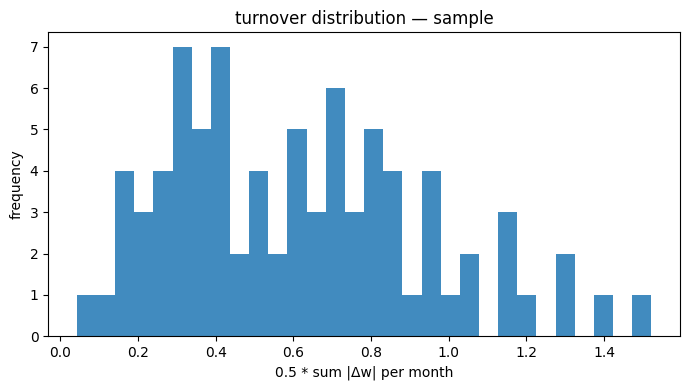

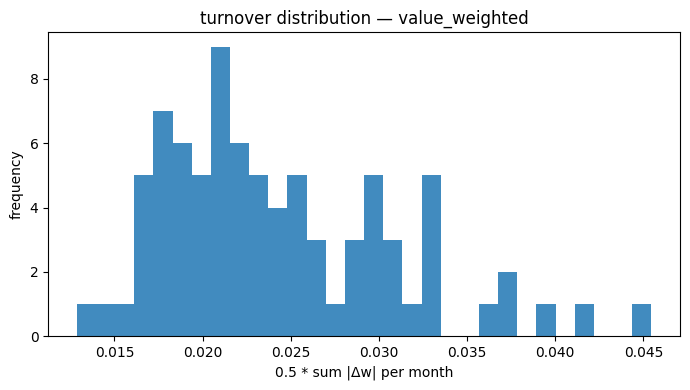

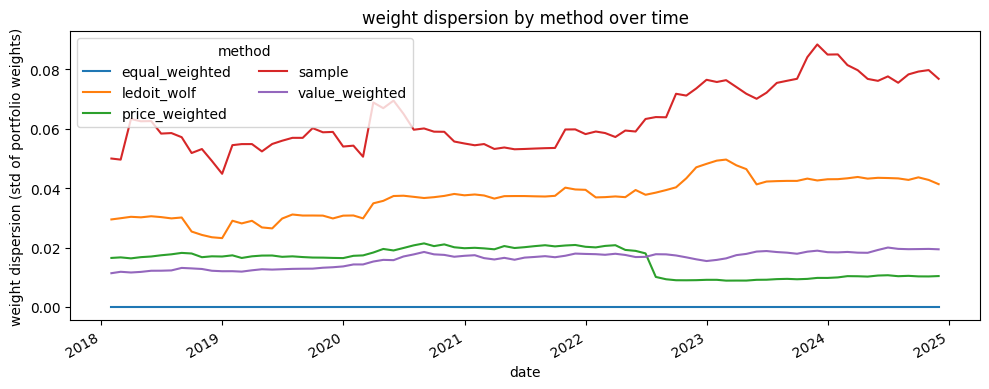

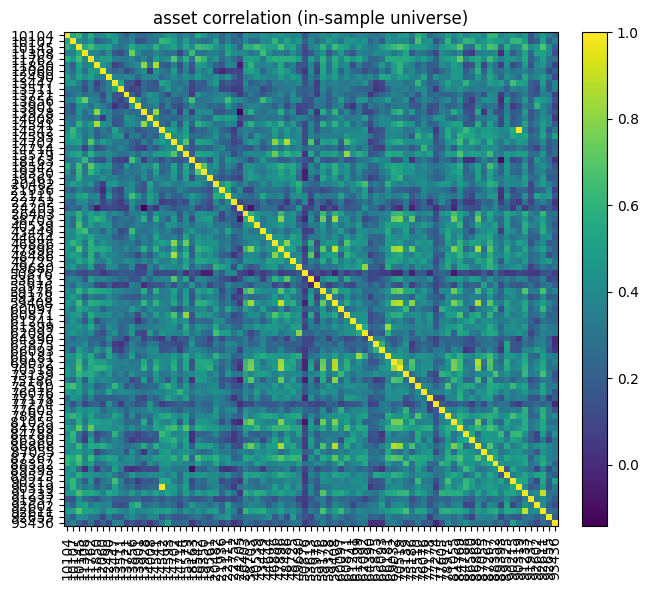

In [25]:
turnover_df = compute_turnover(weights_df)
weights_stability_df = compute_weight_stability(weights_df)
make_all_charts(perf_df, turnover_df, weights_stability_df, raw_returns_wide)